# **Text Scraping from Web**

# Part 1: Data Collection

## **Import Libraries**

In [ ]:
import requests
import time
from bs4 import BeautifulSoup
import pandas as pd
import os
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from tqdm import tqdm
import re
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


มีการใช้ library ดังนี้

*   requests สำหรับการดึงข้อมูลจาก url
*   time สำหรับหยุดการทำงานของ code

*   BeautifulSoup สำหรับการสกัดข้อมูลจาก html
*   pandas สำหรับการจัดการข้อมูล 

*   os สำหรับการบันทึกข้อมูล








## **Make Directories**

In [ ]:
# create directories
os.makedirs("data/datastore", exist_ok=True)
os.makedirs("data/target", exist_ok=True)

ใช้คำสั่ง makedirs จาก os เพื่อสร้าง folder ที่ชื่อ data และสร้าง subfolder 2 ส่วน ได้แก่


1.   datastore จัดเก็บข้อมูลของพาดหัวบทความและเนื้อหา
2.   target จัดเก็บข้อมูลของหมวดหมู่บทความ

<img src="https://drive.google.com/uc?export=view&id=1PSmVbB9S1jbung8Z2wyd-mJ7BbuuUNro" width=400>

## **Web Request**



In [ ]:
# web request
url = 'http://www.it.kmitl.ac.th/~teerapong/news_archive/index.html'
res = requests.get(url)
res.raise_for_status() # check error
soup = BeautifulSoup(res.content.decode('utf-8'),'html.parser')
time.sleep(1)

ดึงข้อมูลจาก www.it.kmitl.ac.th/~teerapong/news_archive/index.html ซึ่งเป็นเว็บที่จัดเก็บบทความต่าง ๆ ในปี 2017 ด้วย library requests โดยใช้คำสั่ง get และใช้ BeautifulSoup ในการดึงข้อมูลออกมาจาก html

## **Extract Month Url**

In [ ]:
# extract month url
get_month_url = [] # เก็บ url ของแต่ละเดือน

for num in soup('a'): # loop tag a
  # example num : <a href="month-jan-2017.html">January</a>

  month = num.get('href') # สกัดข้อความใน href
  # example month : month-jan-2017.html

  if month != '#':
    get_month_url.append('http://www.it.kmitl.ac.th/~teerapong/news_archive/'+month) # เพ่ิม url ของแต่ละเดือนเข้าไปใน get_month_url

time.sleep(1)

In [ ]:
# ตัวอย่างข้อมูลใน get_month_url
get_month_url[0:5]

['http://www.it.kmitl.ac.th/~teerapong/news_archive/month-jan-2017.html',
 'http://www.it.kmitl.ac.th/~teerapong/news_archive/month-feb-2017.html',
 'http://www.it.kmitl.ac.th/~teerapong/news_archive/month-mar-2017.html',
 'http://www.it.kmitl.ac.th/~teerapong/news_archive/month-apr-2017.html',
 'http://www.it.kmitl.ac.th/~teerapong/news_archive/month-may-2017.html']

เนื่องจากเว็บมีลักษณะแยกจัดเก็บบทความเป็นรายเดือนดังรูป

<img src="https://drive.google.com/uc?export=view&id=1Le7caOnvmWgQjet9lPrcybHoI2_Reoi0" width="500">

โดยในแต่ละเดือนนั้นจะมีการเปลี่ยน url ของส่วนเดือน เช่น

เดือนมกราคม : http://www.it.kmitl.ac.th/~teerapong/news_archive/month-jan-2017.html

เดือนกุมภาพันธ์ : http://www.it.kmitl.ac.th/~teerapong/news_archive/month-feb-2017.html

.

จึงใช้ loop ในการสกัด url ของทุกเดือนออกมาด้วยวิธีการดึง html และเลือก loop ใน *tag a*และใส่ข้อความไว้ใน list ที่ชื่อว่า get_month_url

<img src="https://drive.google.com/uc?export=view&id=1NCEjnfVQLUx338ANA5eSZsEHOGdwxpxU" width="200">

<img src="https://drive.google.com/uc?export=view&id=1DmCJM_IqQGJyRh0S7RzGTwHsCECrFZqZ" width="300">

## **Extract Article Category**

In [ ]:
# extract article category
get_category = [] # เก็บข้อมูลหมวดหมู่ข่าว

for month in get_month_url:
  res = requests.get(month)
  soup = BeautifulSoup(res.content.decode('utf-8'),'html.parser')

  for i in soup.select('.category'):
    # example i : <td align="left" class="category"> technology</td>

    text = i.string.strip()
    # example text : technology

    if text != "N/A":
      get_category.append(text) # เพิ่ม text ที่ผ่านเงื่อนไขเข้าไปใน get_category

time.sleep(1)

สกัดข้อมูลของ category ที่มีอยู่ทั้งหมดในเดือนนั้น ๆ

<img src="https://drive.google.com/uc?export=view&id=11JrUkBxJFeSHyhTYAIxxv-L6uk3d3HJQ" width=600>

โดยการ loop ใน *class category* ของทุกบทความ

<img src="https://drive.google.com/uc?export=view&id=1SI53ncYsTK8JwXMqGBrHE_tEqu6sLpNF" width=500>

.

<img src="https://drive.google.com/uc?export=view&id=1evLZNIp5fTcP5gqPmOck0ZGVCe1NyiAV" width=200>

มีเงื่อนไขดังนี้

1. ค่าที่ได้จะต้องไม่ใช่ N/A

<img src="https://drive.google.com/uc?export=view&id=1CZEljcwyhJxCHthLkUgmxSycKc-QeDiA" width=400>

จากนั้นเก็บ category ทั้งหมดไว้ใน list ที่ชื่อว่า get_category

In [ ]:
# create category dataframe
category = pd.DataFrame(get_category, columns=['category'])
category

,category
0,technology
1,business
2,technology
3,business
4,sport
...,...
1403,sport
1404,business
1405,business
1406,business


นำข้อมูลจาก get_category เก็บลงใน dataframe ที่ชื่อว่า category

## **Extract Title**

In [ ]:
# extract title
get_title = [] # เก็บข้อมูลพาดหัวข่าว

for title in get_month_url:
  res = requests.get(title)
  soup = BeautifulSoup(res.content.decode('utf-8'),'html.parser')
  for i in soup.select('td.title > a'):
    # example i : <a href="article-jan-0418.html">21st-Century Sports: How Digital Technology Is Changing the Face Of The Sporting Industry</a>

    text = i.text.strip()
    # example text : 21st-Century Sports: How Digital Technology Is Changing the Face Of The Sporting Industry

    get_title.append(text) # เพิ่ม text เข้าไปใน get_title

time.sleep(1)

เก็บข้อมูลพาดหัวข่าวทั้งหมดในหน้ารวมบทความของเดือนนั้น ๆ

<img src="https://drive.google.com/uc?export=view&id=1EvwaD-z6DtKRk3uN0kKj84pgEQNu6pPa" width=600>

โดยการ loop ใน *td.title > a* และเก็บพาดหัวข่าวทั้งหมดไว้ใน list ที่ชื่อว่า get_title

<img src="https://drive.google.com/uc?export=view&id=1c8yPZUufcYbsGiIGgiJU_PwJEEc-YsNJ" width=600>



In [ ]:
# create title dataframe
title = pd.DataFrame(get_title, columns=['title'])
title

,title
0,21st-Century Sports: How Digital Technology Is...
1,Asian quake hits European shares
2,BT offers free net phone calls
3,Barclays shares up on merger talk
4,Barkley fit for match in Ireland
...,...
1403,Woodward eyes Brennan for Lions
1404,WorldCom trial starts in New York
1405,Yukos accused of lying to court
1406,Yukos drops banks from court bid


นำข้อมูลจาก get_title เก็บลงใน dataframe ที่ชื่อ title

## **Extract Article Url**

In [ ]:
# extract article url
get_article_url = [] # เก็บ url ของแต่ละบทความ

for month in get_month_url:
  res = requests.get(month)
  soup = BeautifulSoup(res.content.decode('utf-8'),'html.parser')

  for i in soup.select('.title > a'):
    text = i.get('href')
    get_article_url.append('http://www.it.kmitl.ac.th/~teerapong/news_archive/'+text)
    
time.sleep(1)

In [ ]:
# ตัวอย่างข้อมูลใน get_article_url
get_article_url[0:5]

['http://www.it.kmitl.ac.th/~teerapong/news_archive/article-jan-0418.html',
 'http://www.it.kmitl.ac.th/~teerapong/news_archive/article-jan-0027.html',
 'http://www.it.kmitl.ac.th/~teerapong/news_archive/article-jan-0631.html',
 'http://www.it.kmitl.ac.th/~teerapong/news_archive/article-jan-2105.html',
 'http://www.it.kmitl.ac.th/~teerapong/news_archive/article-jan-3300.html']

ดึง url ทุกบทความ โดยใช้ BeautifulSoup ในการดึงข้อมูลออกมาจาก html โดยการ loop ใน *.title > a* 

<img src="https://drive.google.com/uc?export=view&id=1hJxa6DjtkFpRX_8L56J-grLoskMem38K" width=600>

หลังจากได้ข้อความภายใน href จึงนำไปต่อกับ http://www.it.kmitl.ac.th/~teerapong/news_archive/ และเก็บ url ของทุกบทความลงใน list ที่มีชื่อว่า get_article_url



## **Extract Article Content**

In [ ]:
# extract article content
exclude = ['Comments are closed for this article.','Return to article search results'] 
get_content = [] # เก็บเนื้อหาข่าว


for article in get_article_url:
  res = requests.get(article)
  soup = BeautifulSoup(res.content.decode('utf-8'),'html.parser')
  staging = ''

  for content in soup.select('p'):
    if (content.text in get_title) or (content.text in exclude):
      pass
    elif content.text == '':
      staging = staging + ' '
    else:
      text = content.text
      staging = staging+text
  get_content.append(staging.strip())
time.sleep(1)

<img src="https://drive.google.com/uc?export=view&id=1T5s0MhlEp6WNpMItnNVYY8Wcv4PVGfk7" width=800>

สกัดเนื้อหาบทความโดย loop ใน get_article_url จะได้เป็น url ของแต่ละบทความ โดยใช้ BeautifulSoup ในการดึงข้อมูลจาก html จากนั้น loop tag p และสร้าง staging เป็น string เปล่าสำหรับการรวมข้อความจากหลาย tag p ให้อยู่ใน text เดียวกัน โดยมีเงื่อนไขดังนี้

1. กรณีที่ข้อความเป็นพาดหัวเรื่องหรือเป็นข้อความใน exclude ให้ผ่าน
2. กรณีที่ข้อความเป็น tag p เปล่าๆ จะเพิ่มช่องว่างเข้าไปใน staging
3. กรณีที่ข้อความเป็น tag p ปกติ จะเพิ่มข้อความเข้าไปใน staging

หลังจากนั้นจะเพิ่ม staging เข้าใน list ที่มีชื่อว่า get_content และในกรณีที่มีช่องว่างหน้าและหลังข้อความจะตัดช่องว่างนั้นออกก่อนด้วยฟังก์ชัน strip()

In [ ]:
content = pd.DataFrame(get_content, columns=['content'])
content

,content
0,The sporting industry has come a long way sinc...
1,Shares in Europe's leading reinsurers and trav...
2,BT is offering customers free internet telepho...
3,Shares in UK banking group Barclays have risen...
4,England centre Olly Barkley has been passed fi...
...,...
1403,Toulouse's former Irish international Trevor B...
1404,"The trial of Bernie Ebbers, former chief execu..."
1405,Russian oil firm Yukos lied to a US court in a...
1406,Russian oil company Yukos has dropped the thre...


นำข้อมูลจาก get_content เก็บลงใน dataframe ที่ชื่อ content

## **Combine Article Title + Content**

In [ ]:
# combine article title and content into the same row
merge = title['title']+' '+content['content']
get_titlepluscontent = merge.values.tolist()

In [ ]:
# ตัวอย่างข้อมูลใน get_titlepluscontent
get_titlepluscontent[0]

'21st-Century Sports: How Digital Technology Is Changing the Face Of The Sporting Industry The sporting industry has come a long way since the ‘60s. It has carved out for itself a niche with its roots so deep that I cannot fathom the sports industry showing any sign of decline any time soon - or later. The reason can be found in this seemingly subtle difference - other industries have customers; the sporting industry has fans. Vivek Ranadivé, leader of the ownership group of the NBA’s Sacramento Kings, explained it beautifully, “Fans will paint their face purple, fans will evangelize. ... Every other CEO in every business is dying to be in our position — they’re dying to have fans.“ While fan passion alone could almost certainly keep the industry going, leagues and sporting franchises have decided not to rest on their laurels. The last few years have seen the steady introduction of technology into the world of sports - amplifying fans’ appreciation of games, enhancing athletes’ public 

นำข้อมูลจาก 2 dataframe ได้แก่ title และ content มารวมกันใน merge

จากนั้นนำข้อมูลใน merge มาสร้างเป็น list ที่ชื่อ get_titlepluscontent

## **Save a Text File**

In [ ]:
# save article content in text file
with open(r'/content/data/datastore/AllArticles_OnlyContent.txt', 'w') as fp:
    for item in get_content:
        # write each item on a new line
        fp.write("%s\n" % item)

บันทึกข้อมูล เนื้อหาของทุกบทความ ในรูปแบบ txt ลงใน datastore

In [ ]:
# save article title and content in text file
with open(r'/content/data/datastore/AllArticles_HeadingPlusContent.txt', 'w') as fp:
    for item in get_titlepluscontent:
        # write each item on a new line
        fp.write("%s\n" % item)

บันทึกข้อมูลพาดหัวเรื่องและเนื้อหาของทุกบทความ ในรูปแบบ txt ลงใน datastore

In [ ]:
# save article category content in text file
with open(r'/content/data/target/category.txt', 'w') as fp:
    for item in get_category:
        # write each item on a new line
        fp.write("%s\n" % item)

บันทึกข้อมูล ทุกหมวดหมู่ ในรูปแบบ txt ลงใน target

# Part 2 : Text Classification


## Load Data

In [ ]:
# load content data
with open("/content/data/datastore/AllArticles_OnlyContent.txt", "r", encoding="utf-8") as f:
    content_data = f.read().split("\n")
    content_data.pop(-1)
    f.close()

In [ ]:
# load heading+content data
with open("/content/data/datastore/AllArticles_HeadingPlusContent.txt", "r", encoding="utf-8") as f:
    headcont_data = f.read().split("\n")
    headcont_data.pop(-1)
    f.close()

In [ ]:
# load category data
with open("/content/data/target/category.txt", "r", encoding="utf-8") as f:
    label_data = f.read().split("\n")
    label_data.pop(-1)
    f.close()

In [ ]:
# create a dataframe from content and category
article = pd.DataFrame(list(zip(content_data, headcont_data, label_data)),
                  columns =['content', 'headingandcontent','label'])
article.head(10)

,content,headingandcontent,label
0,The sporting industry has come a long way sinc...,21st-Century Sports: How Digital Technology Is...,technology
1,Shares in Europe's leading reinsurers and trav...,Asian quake hits European shares Shares in Eur...,business
2,BT is offering customers free internet telepho...,BT offers free net phone calls BT is offering ...,technology
3,Shares in UK banking group Barclays have risen...,Barclays shares up on merger talk Shares in UK...,business
4,England centre Olly Barkley has been passed fi...,Barkley fit for match in Ireland England centr...,sport
5,Newcastle boss Graeme Souness has reopened his...,Bellamy under new fire Newcastle boss Graeme S...,sport
6,Liverpool may launch an £8m January bid for lo...,Benitez 'to launch Morientes bid' Liverpool ma...,sport
7,Liverpool manager Rafael Benitez admitted vict...,Benitez delight after crucial win Liverpool ma...,sport
8,The arrival of new titles in the popular Medal...,Big war games battle it out The arrival of new...,technology
9,Visitors to the British Library will be able t...,British Library gets wireless net Visitors to ...,technology


## Text Pre-Processing

In [ ]:
def lemma_tokenizer_w_pos_tag(text):
    # define a nested function for converting POS tag for Lemmatizer
    def convert_tags(tag):
        if tag == 'vbd' or tag == 'vbg' or tag == 'vbz':
            return 'v'
        else: 
            return 'n'

    # use the standard scikit-learn tokenizer first
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    tokens_with_pos_tag = nltk.pos_tag(tokens)

    # then use NLTK to perform lemmatisation on each token
    lemmatizer = nltk.WordNetLemmatizer()
    lemma_tokens = []
    for token in tokens_with_pos_tag:
        new_tag = convert_tags(token[1].lower()) # covert character to lowercase
        lemma_tokens.append(lemmatizer.lemmatize(token[0], new_tag))
    return lemma_tokens

ใช้การ lemmatize เพื่อแปลงคำต่าง ๆ ให้อยู่ในรูปพื้นฐานของคำนั้น ๆ

โดยสร้างฟังก์ชัน ดังนี้

*  **lemma_tokenizer_w_pos_tag** ฟังก์ชันสำหรับตัดคำ 

*  **convert_tags()**
ฟังก์ชันสำหรับหาประเภทของคำและกรองเฉพาะประเภทคำที่ต้องการ โดยในที่นี้สนใจแค่คำนามและคำกริยา

In [ ]:
# Term weighting
tfidf = TfidfVectorizer(stop_words='english',min_df=3,tokenizer=lemma_tokenizer_w_pos_tag)
X = tfidf.fit_transform(article.content)
print(X.shape)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'u'] not in stop_words.
  warnings.warn(


(1408, 8172)


ใช้ TF-IDF เพื่อวัดความถี่ของคำแต่ละคำที่ปรากฏในเอกสารและวัดความสำคัญของคำในเอกสาร ถ้าคำเจอในเอกสารหลายครั้งหมายความว่าคำนั้นมีความสำคัญน้อยลง โดยใช้ weight ดังนี้
*   stop_words คือคำที่พบบ่อยในเอกสาร ซึ่งไม่มีความสำคัญ ทำให้ข้อมูลและความซับซ้อนน้อยลง
*   min_df ใช้เพื่อกรองคำที่เจอน้อยกว่า 3 เอกสาร
*   tokenizer ใช้ตัดคำ โดยใช้จากฟังก์ชัน lemma_tokenizer_w_pos_tag



## Feature/Label

In [ ]:
X = tfidf.fit_transform(article.content).toarray() # feature from content data
X2 = tfidf.fit_transform(article.headingandcontent).toarray() # feature from heading and content data
y = article.label # target

In [ ]:
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05051089, 0.        , ..., 0.        , 0.        ,
        0.05409507],
       [0.        , 0.0271994 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.02247034, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Article Content Only Modeling

### Split train/test

In [ ]:
# Split train 70% & test 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Random Forest

เลือกใช้ Model นี้เนื่องจากเป็น Model ที่ถูกพัฒนาขึ้นจาก Decision Tree ต่างกันที่ Random Fores มี Tree หลาย ๆ  ต้น ทำให้ประสิทธิภาพในการทำงานสูงขึ้น แม่นยำมากขึ้นมากกว่า  Decision Tree  ซึ่งโมเดล Random Forest เป็นโมเดลที่ได้รับความนิยมไปอย่างมากในการทำ Classification


#### Baseline model with default parameters

In [ ]:
# create a based model
rfc = RandomForestClassifier(random_state=42)

In [ ]:
# fit model
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# evaluating model
rfc_predicted = rfc.predict(X_test)
print(classification_report(y_test, rfc_predicted))
print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, rfc_predicted)*100))

              precision    recall  f1-score   support

    business       0.95      0.98      0.97       167
       sport       0.97      0.98      0.98       143
  technology       0.97      0.92      0.95       113

    accuracy                           0.96       423
   macro avg       0.97      0.96      0.96       423
weighted avg       0.96      0.96      0.96       423

Accuracy = 96.4539%.


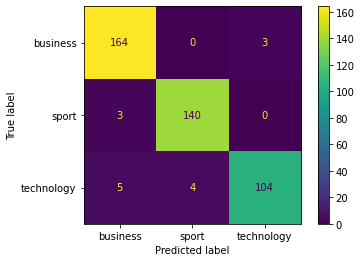

In [ ]:
# confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, rfc_predicted)
confusion = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['business', 'sport', 'technology'])
confusion.plot()
plt.show()

#### Hyperparameter Tuning

In [ ]:
# create a based model
rfc = RandomForestClassifier(random_state=42)

# create the parameter grid based on the results of random search 
param_grid = { 
    'n_estimators': [200, 300, 400, 500],
    'max_features': ['sqrt'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

# instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 5)

In [ ]:
# fit the grid search to the data
grid_search.fit(X_train, y_train)

In [ ]:
# get best estimator for voting classifier
rfc_best = grid_search.best_estimator_
print(grid_search.best_params_)

In [ ]:
# evaluating model
rfc_predicted = rfc_best.predict(X_test)
print(classification_report(y_test, rfc_predicted))
print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, rfc_predicted)*100))

In [ ]:
# confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, rfc_predicted)
confusion = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['business', 'sport', 'technology'])
confusion.plot()
plt.show()

**Tool : GridSearch (ใช้ในทุก ๆ model ต่อไปนี้)**

เนื่องจากเป็นการหาค่า parameter แบบ Systematic โดยวิธีกำหนดค่าของแต่ละ parameter ที่ต้องการจะลอง test จากนั้นrun  model ในทุก ๆ ชุดของค่า parameter ที่เป็นไปได้ โดยการจับทุกๆ parameter มา train โดยมีข้อเสีย คือ ต้องกำหนดค่า parameter ให้เหมาะสมตั้งแต่แรก ซึ่งถ้าค่าที่ดีสุดไม่ได้อยู่ในกลุ่มที่เลือกไว้ก็จะทำให้พลาดในการหา parameter ที่ดีสุด
อีกทั้งยังเป็นเป็นเครื่องมือที่ช่วยในการปรับค่า parameter ต่าง ๆ ของ model อยู่ภายใน package 
ที่รายละเอียดงานกำหนดเอาไว้อย่าง sklearn ด้วย


**มี Parameters ที่กำหนด ดังนี้**
*  n_estimators =  200, 300, 400, 500
*  max_features =  sqrt
*  max_depth = 4,5,6,7,8
*  criterion = gini, entropy
*  cv = 5


**เปรียบเทียบประสิทธิภาพของ model**

<img src="https://drive.google.com/uc?export=view&id=1m5aNxDWOuazPNJqzJKubh3H16k8X_NpH" width="500">

**สรุปผลการใช้ RandomForest**

จากการเปรียบเทียบประสิทธิภาพของ model จะเห็นได้ว่า เมื่อ tune model ตามค่า paraneter ที่กำหนดแล้ว ประสิทธิภาพของ Random Forest ลดลงจาก 96.6903% เหลือ 95.9811% คิดเป็นส่วนต่างที่ 0.792%  โดยส่วนมากนั้นทำนายในส่วนของประเภทบทความ Technology  ผิดพลาดมากยิ่งขึ้น

#### Cross Validation with Best Parameters Model

In [ ]:
# cross validation 5 folds
all_accuracy = cross_val_score(rfc, X, y, cv=5)
print('Mean Accuracy = {:0.4f}%.'.format(all_accuracy.mean()*100))

### Support Vector Classifier (SVC)

เลือกใช้ Model นี้เนื่องจากเป็น Model ที่ถูกพัฒนาขึ้นสำหรับ Binary classification แต่ก็สามารถนำไปประยุกต์ใช้กับ Multiclass classification ได้ด้วย จึงมีทั้งความยึดหยุ่นและสามารถทำงานได้ดี โดยเฉพาะอย่างยิ่งเมื่อข้อมูลมีความซับซ้อน แต่จำนวนตัวอย่างไม่มาก

#### Baseline model with default parameters

In [ ]:
# create a based model
svc = SVC(random_state=42)

In [ ]:
# fit model
svc.fit(X_train, y_train)

In [ ]:
# evaluating model
svc_predicted = svc.predict(X_test)
print(classification_report(y_test, svc_predicted))
print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, svc_predicted)*100))

In [ ]:
# confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, svc_predicted)
confusion = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['business', 'sport', 'technology'])
confusion.plot()
plt.show()

#### Hyperparameter Tuning

In [ ]:
# create a based model
svc = SVC(random_state=42)

# create the parameter grid based on the results of random search 
param_grid = { 
    'kernel': ['sigmoid'],
    'C': [10, 1.0, 0.1],
    'gamma' : ['scale']
}
cv = RepeatedStratifiedKFold(n_splits=5, random_state=42)

# instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, n_jobs=-1, cv=cv)

In [ ]:
# fit the grid search to the data
grid_search.fit(X_train, y_train)

In [ ]:
# get best estimator for voting classifier
svc_best = grid_search.best_estimator_
print(grid_search.best_params_)

In [ ]:
# evaluating model
svc_predicted = svc_best.predict(X_test)
print(classification_report(y_test, svc_predicted))
print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, svc_predicted)*100))

In [ ]:
# confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, svc_predicted)
confusion = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['business', 'sport', 'technology'])
confusion.plot()
plt.show()

**มี Parameters ที่กำหนด ดังนี้**
*  Kernel =  ['sigmoid']
*  C =  [10, 1.0, 0.1]
*  gamma = ['scale']


**เปรียบเทียบประสิทธิภาพของ model**

<img src="https://drive.google.com/uc?export=view&id=13JwFpqwE3hRsqhiGaGtoLl49pUX7sEgj" width="500">

**สรุปผลการใช้ Support Vector Classifier (SVC)**

จากการเปรียบเทียบประสิทธิภาพของ model จะเห็นได้ว่า เมื่อ tune model ตามค่า paraneter ที่กำหนดแล้ว ประสิทธิภาพของ Support Vector Classifier  เพิ่มขึ้นจาก 98.8180% เหลือ 99.0544% คิดเป็นส่วนต่างที่ 0.2364%  ซึ่งถือว่าไม่มีการเปลี่ยนแปลงมากนัก

#### Cross Validation with Best Parameters Model

In [ ]:
# cross validation 5 folds
all_accuracy = cross_val_score(svc_best, X, y, cv=5)
print('Mean Accuracy = {:0.4f}%.'.format(all_accuracy.mean()*100))

### Logistic Regression

เลือกใช้ Model นี้เนื่องจาก Logistic regression เป็น Model ที่ใช้กับปัญหา binary classification ที่ตัวแปรตามเป็นแบบ 1/0 เป็นหลัก แต่ก็สามารถทำ multi classification ได้ด้วยเช่นกัน ดังนั้นในปัจจุบันจึงเป็นอีกหนึ่ง model ที่ได้รับความนิยมในการทำ classification

#### Baseline model with default parameters

In [ ]:
# create a based model
log = LogisticRegression(random_state=42)

In [ ]:
# fit model
log.fit(X_train, y_train)

In [ ]:
# evaluating model
log_predicted = log.predict(X_test)
print(classification_report(y_test, log_predicted))
print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, log_predicted)*100))

In [ ]:
# confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, log_predicted)
confusion = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['business', 'sport', 'technology'])
confusion.plot()
plt.show()

#### Hyperparameter Tuning

In [ ]:
# create a based model
log = LogisticRegression(random_state=42)

# create the parameter grid based on the results of random search 
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
cv = RepeatedStratifiedKFold(n_splits=5, random_state=42)
param_grid = dict(penalty=penalty,C=c_values)

# instantiate the grid search model
grid_search = GridSearchCV(estimator=log, param_grid=param_grid, cv=cv)

In [ ]:
# fit the grid search to the data
grid_result = grid_search.fit(X_train, y_train)

In [ ]:
# get best estimator for voting classifier
log_best = grid_search.best_estimator_
print(grid_search.best_params_)

In [ ]:
# evaluating model
log_predicted = log_best.predict(X_test)
print(classification_report(y_test, log_predicted))
print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, log_predicted)*100))

In [ ]:
# confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, log_predicted)
confusion = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['business', 'sport', 'technology'])
confusion.plot()
plt.show()

**มี Parameters ที่กำหนด ดังนี้**

* penalty = ['l2']
* c_values = [100, 10, 1.0, 0.1, 0.01]
* N_splits = 5
* Random_state = 42


**เปรียบเทียบประสิทธิภาพของ model**

<img src="https://drive.google.com/uc?export=view&id=1xLOBW9iUokzcQLVRnJcbdCzLmyMBhqR9" width="500">

**สรุปผลการใช้ Logistic Regression**

จากการเปรียบเทียบประสิทธิภาพของ model จะเห็นได้ว่า เมื่อ tune model ตามค่า parameter ที่กำหนดแล้ว ประสิทธิภาพของ Support Vector Classifier  เพิ่มขึ้นจาก 98.8180% เหลือ 99.0544% คิดเป็นส่วนต่างที่ 1.1821%   โดยส่วนมากนั้นทำนายในส่วนของประเภทบทความ Technology  ถูกต้องมากยิ่งขึ้น


#### Cross Validation with Best Parameters Model

In [ ]:
# cross validation 5 folds
all_accuracy = cross_val_score(log_best, X, y, cv=5)
print('Mean Accuracy = {:0.4f}%.'.format(all_accuracy.mean()*100))

### All Model Comparison

**เปรียบเทียบประสิทธิภาพของทุกโมเดล**

จากการทำการปรับ parameter ทำให้เห็นว่าในบางโมเดล ประสิทธิภาพลดลง ดังนั้นจึงจะใช้โมเดลที่มีค่า accuracy สูงสุดในแต่ละประเภท ในการทำ cross validation 5-fold  เพื่อหาประสิทธิภาพที่แท้จริงของทั้ง 3 โมเดล

<img src="https://drive.google.com/uc?export=view&id=139FdvRzHsmB0kyykXUJ-vRiX9gqwoVYa" width="500">

จะเห็นได้ว่าโมเดลที่ดีที่สุดคือ Logistic Regression ซึ่งมีค่า ซึ่งมีค่า accuracy อยู่ที่ 98.3660% โดยก่อนการปรับค่า parameter Logistic Regression นั้นมีค่า accuracy น้อยกว่า Support Vector Classifier (SVC) และเมื่อปรับแล้วค่า accuracy แล้ว จึงมีค่า accuracy เท่ากับ Support Vector Classifier (SVC) ในขั้นตอนสุดท้าย หรือการทำ cross validation 5-fold ทำให้ทราบประสิทธิภาพที่แท้จริงของ model ที่มาจากการแบ่งชุดข้อมูลเป็น 5 กลุ่ม แล้ว train ดังรูป ทำให้ทราบว่า Support Vector Classifier (SVC) มีจุดบกพร่องมากกว่า Logistic Regression

<img src="https://drive.google.com/uc?export=view&id=1fQ5MyLvB8XCcphkgWpJPGsTVOzDaF9vF" width="500">

## Article Heading and Content Modeling

### Split train/test

In [ ]:
# Split train 70% & test 30%
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=42)

### Random Forest

#### Baseline model with default parameters

In [ ]:
# create a based model
rfc = RandomForestClassifier(random_state=42)

In [ ]:
# fit model
rfc.fit(X_train, y_train)

In [ ]:
# evaluating model
rfc_predicted = rfc.predict(X_test)
print(classification_report(y_test, rfc_predicted))
print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, rfc_predicted)*100))

In [ ]:
# confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, rfc_predicted)
confusion = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['business', 'sport', 'technology'])
confusion.plot()
plt.show()

#### Hyperparameter Tuning

In [ ]:
# create a based model
rfc = RandomForestClassifier(random_state=42)

# create the parameter grid based on the results of random search 
param_grid = { 
    'n_estimators': [200, 300, 400, 500],
    'max_features': ['sqrt'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

# instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 5)

In [ ]:
# fit the grid search to the data
grid_search.fit(X_train, y_train)

In [ ]:
# get best estimator for voting classifier
rfc_best = grid_search.best_estimator_
print(grid_search.best_params_)

In [ ]:
# evaluating model
rfc_predicted = rfc_best.predict(X_test)
print(classification_report(y_test, rfc_predicted))
print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, rfc_predicted)*100))

In [ ]:
# confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, rfc_predicted)
confusion = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['business', 'sport', 'technology'])
confusion.plot()
plt.show()

**เปรียบเทียบประสิทธิภาพของ model**

<img src="https://drive.google.com/uc?export=view&id=1H7IeyMQA8kTSOv8lmFbxvMKsxGZDWjoo" width="500">

**สรุปผลการใช้ RandomForest**

จากการเปรียบเทียบประสิทธิภาพของ model จะเห็นได้ว่า เมื่อ tune model ตามค่า paraneter ที่กำหนดแล้ว ประสิทธิภาพของ Random Forest ลดลงจาก 96.2175% เหลือ 95.5083% คิดเป็นส่วนต่างที่ 0.7092%  โดยส่วนมากนั้นทำนายในส่วนของประเภทบทความ Technology  ผิดพลาดมากยิ่งขึ้น


#### Cross Validation with Best Parameters Model

In [ ]:
# cross validation 5 folds
all_accuracy = cross_val_score(rfc, X, y, cv=5)
print('Mean Accuracy = {:0.4f}%.'.format(all_accuracy.mean()*100))

### Support Vector Classifier (SVC)

#### Baseline model with default parameters

In [ ]:
# create a based model
svc = SVC(random_state=42)

In [ ]:
# fit model
svc.fit(X_train, y_train)

In [ ]:
# evaluating model
svc_predicted = svc.predict(X_test)
print(classification_report(y_test, svc_predicted))
print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, svc_predicted)*100))

In [ ]:
# confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, svc_predicted)
confusion = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['business', 'sport', 'technology'])
confusion.plot()
plt.show()

#### Hyperparameter Tuning

In [ ]:
# create a based model
svc = SVC(random_state=42)

# create the parameter grid based on the results of random search 
param_grid = { 
    'kernel': ['sigmoid'],
    'C': [10, 1.0, 0.1],
    'gamma' : ['scale']
}
cv = RepeatedStratifiedKFold(n_splits=5, random_state=42)

# instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, n_jobs=-1, cv=cv)

In [ ]:
# fit the grid search to the data
grid_search.fit(X_train, y_train)

In [ ]:
# get best estimator for voting classifier
svc_best = grid_search.best_estimator_
print(grid_search.best_params_)

In [ ]:
# evaluating model
svc_predicted = svc_best.predict(X_test)
print(classification_report(y_test, svc_predicted))
print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, svc_predicted)*100))

In [ ]:
# confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, svc_predicted)
confusion = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['business', 'sport', 'technology'])
confusion.plot()
plt.show()

**เปรียบเทียบประสิทธิภาพของ model**

<img src="https://drive.google.com/uc?export=view&id=1YIRy5Rfefx601Smtmxrlo903o8pBWCXT" width="500">

**สรุปผลการใช้ Support Vector Classifier (SVC)**

จากการเปรียบเทียบประสิทธิภาพของ model จะเห็นได้ว่า เมื่อ tune model ตามค่า paraneter ที่กำหนดแล้ว ประสิทธิภาพของ Support Vector Classifier  เพิ่มขึ้นจาก 98.5816% เหลือ 99.0544% คิดเป็นส่วนต่างที่ 0.4728%  ซึ่งถือว่าไม่มีการเปลี่ยนแปลงมากนัก


#### Cross Validation with Best Parameters Model

In [ ]:
# cross validation 5 folds
all_accuracy = cross_val_score(svc_best, X, y, cv=5)
print('Mean Accuracy = {:0.4f}%.'.format(all_accuracy.mean()*100))

### Logistic Regression

#### Baseline model with default parameters

In [ ]:
# create a based model
log = LogisticRegression(random_state=42)

In [ ]:
# fit model
log.fit(X_train, y_train)

In [ ]:
# evaluating model
log_predicted = log.predict(X_test)
print(classification_report(y_test, log_predicted))
print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, log_predicted)*100))

In [ ]:
# confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, log_predicted)
confusion = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['business', 'sport', 'technology'])
confusion.plot()
plt.show()

#### Hyperparameter Tuning

In [ ]:
# create a based model
log = LogisticRegression(random_state=42)

# create the parameter grid based on the results of random search 
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
cv = RepeatedStratifiedKFold(n_splits=5, random_state=42)
param_grid = dict(penalty=penalty,C=c_values)

# instantiate the grid search model
grid_search = GridSearchCV(estimator=log, param_grid=param_grid, cv=cv)

In [ ]:
# fit the grid search to the data
grid_result = grid_search.fit(X_train, y_train)

In [ ]:
# get best estimator for voting classifier
log_best = grid_search.best_estimator_
print(grid_search.best_params_)

In [ ]:
# evaluating model
log_predicted = log_best.predict(X_test)
print(classification_report(y_test, log_predicted))
print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, log_predicted)*100))

In [ ]:
# confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, log_predicted)
confusion = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['business', 'sport', 'technology'])
confusion.plot()
plt.show()

**เปรียบเทียบประสิทธิภาพของ model**

<img src="https://drive.google.com/uc?export=view&id=1jZDUXkGVMNsS8uuXyEpydIBCCRXxZduw" width="500">

**สรุปผลการใช้ Logistic Regression**

จากการเปรียบเทียบประสิทธิภาพของ model จะเห็นได้ว่า เมื่อ tune model ตามค่า parameter ที่กำหนดแล้ว ประสิทธิภาพของ Support Vector Classifier  เพิ่มขึ้นจาก 98.8180% เหลือ 99.0544% คิดเป็นส่วนต่างที่ 1.4185%   โดยส่วนมากนั้นทำนายในส่วนของประเภทบทความ Technology  ถูกต้องมากยิ่งขึ้น


#### Cross Validation with Best Parameters Model

In [ ]:
# cross validation 5 folds
all_accuracy = cross_val_score(log_best, X, y, cv=5)
print('Mean Accuracy = {:0.4f}%.'.format(all_accuracy.mean()*100))

### All Model Comparison

**เปรียบเทียบประสิทธิภาพของทุก model**

<img src="https://drive.google.com/uc?export=view&id=1AqjS8sCcq3_mGn3O_qLWIougVW7xFKBj" width="500">

จะเห็นได้ว่าโมเดลที่ดีที่สุดคือ Logistic Regression ด้วยเหตุผลเดียวกับตอนที่ใช้เพียง content และ label ในการ train เท่านั้น

## Content Model and Heading + Content Model Comparison

**เปรียบเทียบประสิทธิภาพระหว่าง Content Model และ Heading and Content Model ด้วย Cross Validation 5 folds**

<img src="https://drive.google.com/uc?export=view&id=1ylTdyNFtulonjM0uxbEgbCqUwEss_Asl" width="500">

เมื่อเปรียบเทียบประสิทธิภาพของการ train ที่มี heading และไม่มี heading จะพบว่าไม่มีความต่างในการทำ Classification มากนักใน RandomForest และ Support Vector Classifier (SVC) แต่ใน Logistic Regression มีประสิทธิภาพเพิ่มขึ้นเล็กน้อยเพียง model เดียวเท่านั้น 
สรุปได้ว่า heading อาจส่งผลให้บาง model นั้นมีประสิทธิภาพดีขึ้นเล็กน้อย เนื่องจาก heading นั้น มีเนื้อหาที่สกัดออกมากได้น้อยกว่า content มาก ดังนั้นจึงมีค่าน้ำน้อย ทำให้ส่งผลต่อ model เล็กน้อยเท่านั้น